In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model.params.Metric import *
from model.params.Kernel import *
from model.params.Window import *

import numpy as np
from model.knnInteractor import KnnInteractor
from model.knnClassifier import KNNClassifier
from model.dataHandler import DataHandler

ultraviolet = '#9A00F5'
pure_aqua = '#00FFFF'
acid_yellow = '#A1FF00'
neon_red = '#FF005D'

### T1. *Prepare data*

In [2]:
handler = DataHandler('data/base_01-10-23__01-03-24.csv', 'document_type')
handler.data.head()

,projectId,department,document_type,title,progress,views,project_card_size_Kb
0,146100,Минздрав России,Проект постановления Правительства Российской ...,О внесении изменений в постановление Правитель...,1.0,315,0.354492
1,146099,Минздрав России,Проект постановления Правительства Российской ...,О внесении изменений в постановление Правитель...,1.0,358,0.354492
2,146098,Минздрав России,Проект ведомственного акта,Об утверждении общих требований к организации ...,1.0,556,0.367188
3,146097,Минздрав России,Проект ведомственного акта,Об утверждении Порядка оповещения законного пр...,1.0,350,0.582031
4,146095,Минсельхоз России,Проект постановления Правительства Российской ...,О внесении изменения в постановление Правитель...,1.0,253,0.359375


In [3]:
handler.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   projectId             3442 non-null   int64  
 1   department            3442 non-null   object 
 2   document_type         3442 non-null   object 
 3   title                 3442 non-null   object 
 4   progress              3442 non-null   float64
 5   views                 3442 non-null   int64  
 6   project_card_size_Kb  3442 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 188.4+ KB


In [4]:
print(handler.data['document_type'].unique())
print(handler.data['document_type'].unique().__len__())
handler.drop_cols(['projectId', 'project_card_size_Kb'])
handler.working_copy.info()

['Проект постановления Правительства Российской Федерации'
 'Проект ведомственного акта' 'Проект федерального закона'
 'Проект Указа Президента Российской Федерации'
 'Распоряжение правительства РФ'
 'Проект указа Президента Российской Федерации'
 'Указ Президента Российской Федерации']
7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     3442 non-null   object 
 1   document_type  3442 non-null   object 
 2   title          3442 non-null   object 
 3   progress       3442 non-null   float64
 4   views          3442 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 134.6+ KB


In [5]:
handler.working_copy['titleLen'] = handler.working_copy['title'].map(lambda  x: x.__len__())

In [6]:
for dep in handler.working_copy['department'].unique():
    print(dep)
    
general_categories = {
    'Минкультуры России': 'civil', 'Минфин России': 'economy', 'ФАС России': 'economy',
    'Минздрав России': 'civil', 'Минюст России': 'juridic', 'ФТС России': 'siloviki',
    'Минобороны России': 'siloviki', 'МЧС России': 'nature', 'Россотрудничество': 'international',
    'Росреестр': 'juridic', 'Росаккредитация': 'juridic', 'СФР': 'civil', 'Росавиация': 'civil',
    'Росводресурсы': 'nature', 'МВД России': 'siloviki', 'Минсельхоз России': 'civil',
    'Минэкономразвития России': 'economy',
    'Минтранс России': 'civil', 'Минпромторг России': 'economy', 'Минобрнауки России': 'civil',
    'Минприроды России': 'nature', 'ФСИН России': 'siloviki', 'Центральный банк Российской Федерации': 'economy',
    'Росавтодор': 'civil', 'Роскомнадзор': 'juridic', 'Минтруд России': 'civil',
    'Минспорт России': 'civil', 'Росалкогольрегулирование': 'juridic', 'Минцифры России': 'juridic',
    'МИД России': 'international', 'Минпросвещения России': 'civil', 'Минстрой России': 'civil',
    'Ростехнадзор': 'juridic', 'Минэнерго России': 'civil', 'ФНС России': 'economy',
    'Госкорпорация "Росатом"': 'economy', 'Росгвардия': 'siloviki',
    'Следственный комитет Российской Федерации': 'siloviki',
    'Росздравнадзор': 'juridic', 'ФМБА России': 'juridic', 'Минкомсвязь России': 'civil',
    'Ространснадзор': 'juridic', 'ГФС России': 'siloviki',
    'Генеральная прокуратура Российской Федерации': 'siloviki', 'Минвостокразвития России': 'economy',
    'ФСБ России': 'siloviki', 'ФСО России': 'siloviki', 'Росстат': 'civil',
    'Рособрнадзор': 'juridic', 'ГУСП': 'siloviki', 'Роспотребнадзор': 'juridic',
    'Рослесхоз': 'nature', 'Казначейство России': 'economy', 'ФССП России': 'siloviki',
    'Россельхознадзор': 'juridic', 'Росрыболовство': 'nature', 'Госкорпорация "Роскосмос"': 'economy',
    'Судебный департамент': 'juridic', 'Росгидромет': 'nature', 'ФФОМС': 'civil',
    'Роспатент': 'economy', 'Росприроднадзор': 'nature',
    'Управление делами Президента Российской Федерации': 'juridic',
    'Росфинмониторинг': 'economy', 'Росимущество': 'juridic', 'Роструд': 'civil',
    'ФСВТС России': 'international', 'Росжелдор' : 'civil', 'Федеральное агентство по делам национальностей': 'civil', 
    'Росмолодежь' : 'civil', 'Росалкогольтабакконтроль':'juridic', 'Росрезерв':'juridic', 'ФСТЭК России':'siloviki',
    'Росархив':'civil', 'Роснедра': 'nature', 'Росморречфлот': 'civil', 'Росстандарт': 'juridic'
}


def generalize_departments(department):
    return general_categories.get(department)


print('--------------------')
gen_departments = set(map(generalize_departments, handler.working_copy['department'].unique()))
for gd in gen_departments:
    print(gd)    

Минздрав России
Минсельхоз России
ФАС России
Минпросвещения России
Минпромторг России
Росрыболовство
Минэкономразвития России
Минтруд России
Росстат
Рослесхоз
Минобрнауки России
Федеральное агентство по делам национальностей
Минтранс России
Минобороны России
Росгидромет
Роснедра
МИД России
Минфин России
Росфинмониторинг
Росприроднадзор
Генеральная прокуратура Российской Федерации
Минюст России
Рособрнадзор
Минспорт России
Ростехнадзор
МВД России
Росреестр
ФФОМС
Минкультуры России
Росморречфлот
МЧС России
Минприроды России
Минэнерго России
Минцифры России
ФТС России
Росавиация
Росалкогольтабакконтроль
Минвостокразвития России
ФНС России
ФСБ России
Госкорпорация "Росатом"
ФМБА России
Центральный банк Российской Федерации
Минстрой России
Россельхознадзор
Роспотребнадзор
Минкомсвязь России
Росгвардия
ГУСП
Росстандарт
ФССП России
Судебный департамент
Россотрудничество
Росимущество
Госкорпорация "Роскосмос"
Следственный комитет Российской Федерации
ФСИН России
Казначейство России
ФСО России


In [7]:
handler.working_copy['departmentGen'] = handler.working_copy['department'].map(generalize_departments)
handler.drop_cols(['department', 'title'])

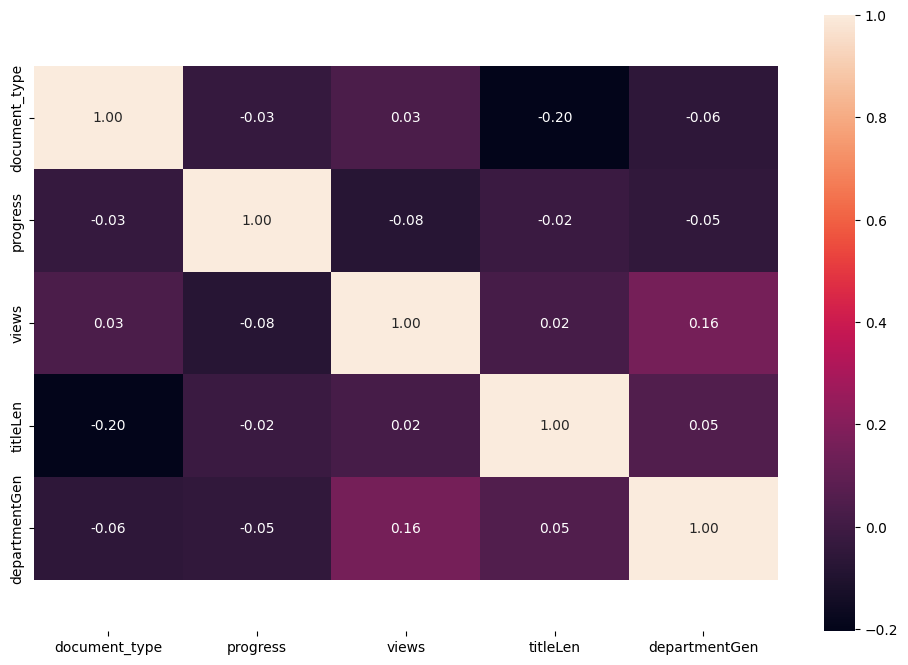

In [8]:
handler.make_correlation()

In [9]:
#handler.logarithm('titleLen')
#handler.logarithm('views')
exdog, endog = handler.make_ex_endog()

exdog.head(10)

,progress,views,titleLen,departmentGen_civil,departmentGen_economy,departmentGen_international,departmentGen_juridic,departmentGen_nature,departmentGen_siloviki
0,1.0,315,96,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,358,96,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,556,126,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,350,278,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,253,97,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,354,69,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,162,234,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,223,190,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,355,96,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,160,155,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
exdog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   progress                     3442 non-null   float64
 1   views                        3442 non-null   int64  
 2   titleLen                     3442 non-null   int64  
 3   departmentGen_civil          3442 non-null   float64
 4   departmentGen_economy        3442 non-null   float64
 5   departmentGen_international  3442 non-null   float64
 6   departmentGen_juridic        3442 non-null   float64
 7   departmentGen_nature         3442 non-null   float64
 8   departmentGen_siloviki       3442 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 242.1 KB


In [11]:
print(np.unique(endog).__len__())
print(f'assertion: {np.unique(endog).__len__() - handler.working_copy[handler.target_col].unique().__len__()}')

7
assertion: 0


**Just for fun**

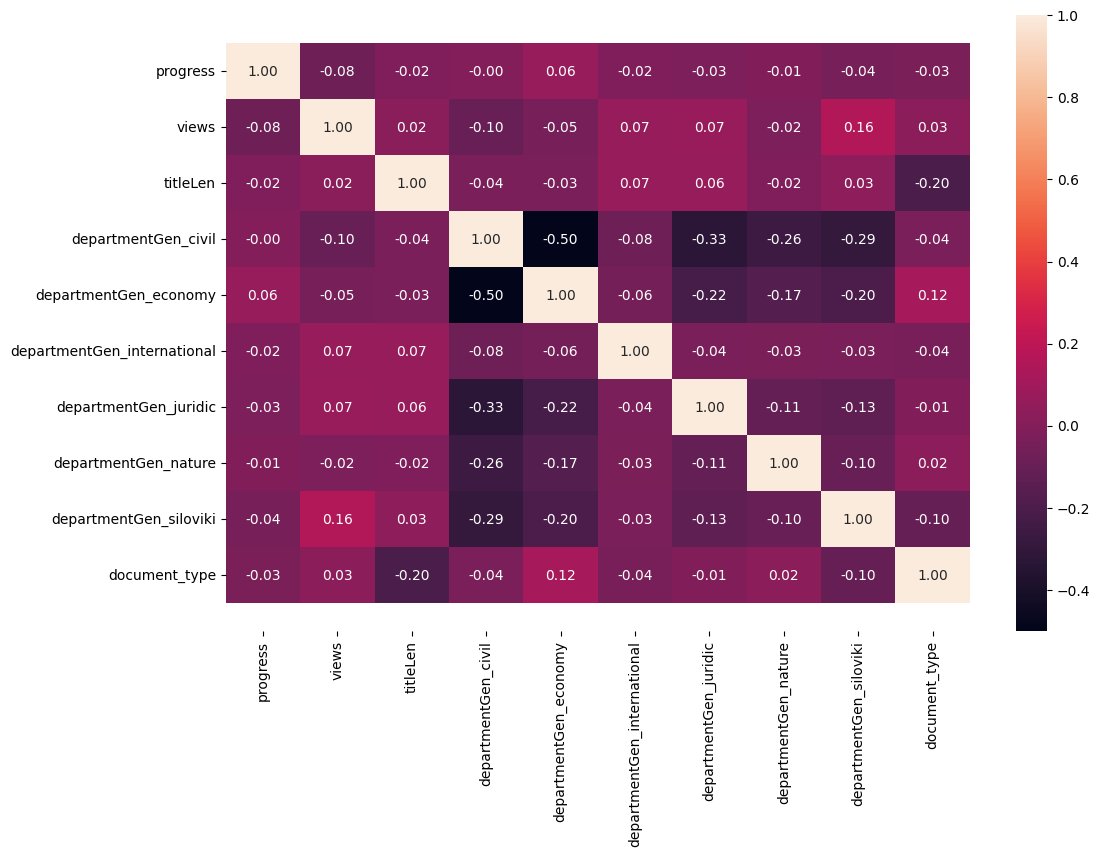

In [12]:
exdog[handler.target_col] = endog
handler.show_correlation(exdog)
exdog = exdog.drop([handler.target_col], axis=1)

### T2. *Set hyperparameters*

***functionality check***

In [13]:
interactor = KnnInteractor(exdog, endog)
knn = KNNClassifier(FixedWindow(0.26), EpanechKernel(), Metric.COSIN).fit(interactor.train_exdog, interactor.train_ans,interactor.default_weights)
predictions = knn.predict(interactor.test_exdog)
print(predictions)

[1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 

In [14]:
print(interactor.accuracy(interactor.test_ans, predictions))

54.862119013062404


**Best parameters for impl**

window: `FIXED -> h[1e-2 : 1.0]` or `relative -> k[1 : train.len]`

kernel: `Uniform`, `Gaussian`, `Triangular`, `Epanechnikov`

metric: `CHEBYSHEV`, `COSINE`, `MINKOWSKI`

In [15]:
interactor.get_best_impl_klassifier()

[I 2024-03-21 06:53:16,447] A new study created in memory with name: no-name-d945d3cb-6d6e-48a4-a2f6-6c3ee66e61ff
C:\Users\chura\Х#й#я\DA_ML\lab1-knn-BrainCallus\knn\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function cosine at 0x0000021B7F822200> which is of type function.
  warnings.warn(message)
C:\Users\chura\Х#й#я\DA_ML\lab1-knn-BrainCallus\knn\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function chebyshev at 0x0000021B7F822660> which is of type function.
  warnings.warn(message)
C:\Users\chura\Х#й#я\DA_ML\lab1-knn-BrainCallus\knn\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str 

 [INFO] KnnInteractor 2024-03-21 06:55:28.733435: Best fixed: FrozenTrial(number=26, state=1, values=[55.442670537010166], datetime_start=datetime.datetime(2024, 3, 21, 6, 53, 18, 800993), datetime_complete=datetime.datetime(2024, 3, 21, 6, 53, 18, 883216), params={'fixed:h': 0.4783473777676909, 'kernel': 'Uniform', 'metric': <function cosine at 0x0000021B7F822200>}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'fixed:h': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'kernel': CategoricalDistribution(choices=('Uniform', 'Gaussian', 'Triangular', 'Epanechnikov')), 'metric': CategoricalDistribution(choices=(<function cosine at 0x0000021B7F822200>, <function chebyshev at 0x0000021B7F822660>, <function minkowski at 0x0000021B7F821F80>))}, trial_id=26, value=None)
 [INFO] KnnInteractor 2024-03-21 06:55:28.733435: Best relative: FrozenTrial(number=0, state=1, values=[62.11901306240929], datetime_start=datetime.datetime(2024, 3, 21, 6, 53, 26, 24132), 

**Best parameters for scikit**

k: `[1 : 500]`

weight function: `uniform`, `distance`

algorithm: `ball_tree`, `kd_tree`, `brute`

minkowski degree(p): `[1.0 : 5.0]`

In [16]:
interactor.get_best_lib_klassifier()

[I 2024-03-21 06:55:28,738] A new study created in memory with name: no-name-1750646a-8b26-4d1e-9266-549a29c7c5fc
[I 2024-03-21 06:55:28,796] Trial 0 finished with value: 57.61973875181422 and parameters: {'k': 29, 'weight function': 'uniform', 'algorithm': 'kd_tree', 'minkowski degree': 1.1001225537051726}. Best is trial 0 with value: 57.61973875181422.
[I 2024-03-21 06:55:28,915] Trial 1 finished with value: 57.03918722786647 and parameters: {'k': 73, 'weight function': 'distance', 'algorithm': 'ball_tree', 'minkowski degree': 1.7339757801404851}. Best is trial 0 with value: 57.61973875181422.
[I 2024-03-21 06:55:29,078] Trial 2 finished with value: 60.37735849056604 and parameters: {'k': 446, 'weight function': 'uniform', 'algorithm': 'kd_tree', 'minkowski degree': 1.841306741536977}. Best is trial 2 with value: 60.37735849056604.
[I 2024-03-21 06:55:29,203] Trial 3 finished with value: 57.61973875181422 and parameters: {'k': 283, 'weight function': 'uniform', 'algorithm': 'brute', 

 [INFO] KnnInteractor 2024-03-21 06:55:45.649178: Best scikit: FrozenTrial(number=63, state=1, values=[62.11901306240929], datetime_start=datetime.datetime(2024, 3, 21, 6, 55, 38, 452519), datetime_complete=datetime.datetime(2024, 3, 21, 6, 55, 38, 641560), params={'k': 499, 'weight function': 'uniform', 'algorithm': 'brute', 'minkowski degree': 4.66626054237433}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'k': IntDistribution(high=500, log=False, low=1, step=1), 'weight function': CategoricalDistribution(choices=('uniform', 'distance')), 'algorithm': CategoricalDistribution(choices=('ball_tree', 'kd_tree', 'brute')), 'minkowski degree': FloatDistribution(high=5.0, log=False, low=1.0, step=None)}, trial_id=63, value=None)
 [INFO] KnnInteractor 2024-03-21 06:55:45.649178: Best scikit params: {'k': 499, 'weight function': 'uniform', 'algorithm': 'brute', 'minkowski degree': 4.66626054237433}


### T3. *Window parameter dependency*

In [17]:
from sklearn.neighbors import KNeighborsClassifier

best_impl_params: (Window, Kernel, Metric) = interactor.best_knn_params_impl
best_lib_params: (int, str, str, float) = interactor.best_knn_params_lib


def get_accuracy_for_k_impl(k_, x, y):
    preds = KNNClassifier(RelativeWindow(k_), best_impl_params[1], best_impl_params[2]).fit(
        interactor.train_exdog, interactor.train_ans, interactor.default_weights).predict(x)
    return interactor.accuracy(y, preds)


def get_accuracy_for_k_lib(k_, x, y):
    preds = KNeighborsClassifier(n_neighbors=k_, weights=best_lib_params[1], algorithm=best_lib_params[2],
                                 p=best_lib_params[3]).fit(
        interactor.train_exdog, interactor.train_ans).predict(x)
    return interactor.accuracy(y, preds)


In [18]:
train_impl, test_impl, train_lib, test_lib = [], [], [], []
ox = [x for x in range(1, 551)]
for k in ox:
    train_impl.append(get_accuracy_for_k_impl(k, interactor.train_exdog, interactor.train_ans))
    train_lib.append(get_accuracy_for_k_lib(k, interactor.train_exdog, interactor.train_ans))
    test_impl.append(get_accuracy_for_k_impl(k, interactor.test_exdog, interactor.test_ans))
    test_lib.append(get_accuracy_for_k_lib(k, interactor.test_exdog, interactor.test_ans))


C:\Users\chura\Х#й#я\DA_ML\lab1-knn-BrainCallus\knn\model\knnClassifier.py:46: RuntimeWarning: invalid value encountered in scalar divide
  kernel_x = dist[i] / self.window.get_kernel_param_divvisor(dist)


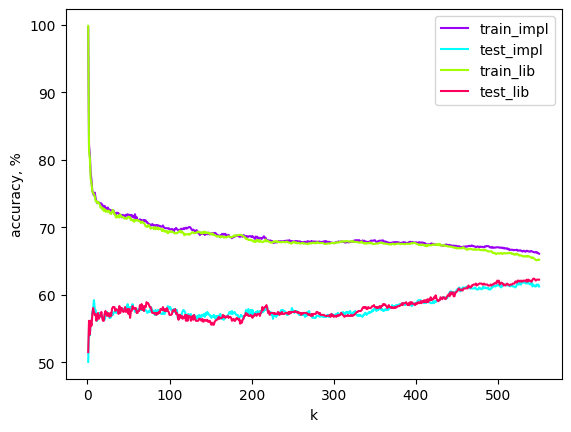

In [19]:
plt.plot(ox, train_impl, label='train_impl', c=ultraviolet)
plt.plot(ox, test_impl, label='test_impl', c=pure_aqua)
plt.plot(ox, train_lib, label='train_lib', c=acid_yellow)
plt.plot(ox, test_lib, label='test_lib', c=neon_red)
plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy, %')
plt.show()

### T4. *Lowess*

In [20]:
_norm, anomalies1, anomalies2 = interactor.get_anomalies(interactor.train_exdog, interactor.train_ans, interactor.best_knn_params_impl)
interactor.logger.info(f'Accuracy: {_norm.__len__() / interactor.train_exdog.__len__() * 100}')
interactor.logger.info(f'1 type anomalies: {anomalies1.__len__()}')
interactor.logger.info(f'2 type anomalies: {anomalies2.__len__()}')

 [INFO] KnnInteractor 2024-03-21 07:12:40.269289: Accuracy: 64.65673810388667
 [INFO] KnnInteractor 2024-03-21 07:12:40.270286: 1 type anomalies: 851
 [INFO] KnnInteractor 2024-03-21 07:12:40.270286: 2 type anomalies: 122


In [21]:
ox = [x * 0.1 for x in range(1, 101)]
oy_train = [interactor.get_accuracy_weighted(interactor.train_exdog,  interactor.train_ans, w,anomalies1, anomalies2) for w in ox]
oy_test = [interactor.get_accuracy_weighted(interactor.test_exdog, interactor.test_ans, w, anomalies1, anomalies2) for w in ox]

Text(0.5, 1.0, 'Weights for train impl')

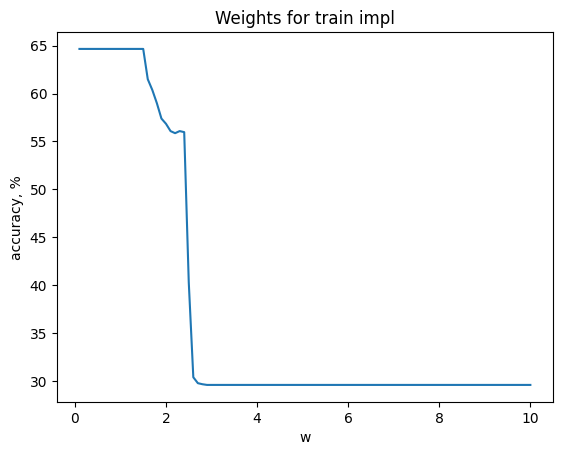

In [22]:
plt.plot(ox, oy_train)
plt.xlabel('w')
plt.ylabel('accuracy, %')
plt.title('Weights for train impl')

Text(0.5, 1.0, 'Weights for test impl')

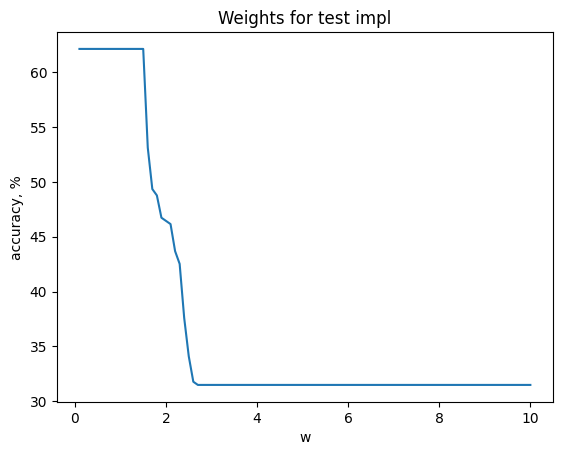

In [23]:
plt.plot(ox, oy_test)
plt.xlabel('w')
plt.ylabel('accuracy, %')
plt.title('Weights for test impl')

In [24]:
def lib_accuracy_sampled(train_x, train_y, test_x, test_y):
    klassifier = KNeighborsClassifier(n_neighbors=best_lib_params[0], weights=best_lib_params[1], algorithm=best_lib_params[2], p=best_lib_params[3])
    preds = klassifier.fit(train_x, train_y).predict(test_x)
    return interactor.accuracy(test_y, preds)

In [25]:
sampled_exdog = pd.concat([interactor.train_exdog, interactor.train_exdog.iloc[anomalies1]])
sampled_endog = np.concatenate((interactor.train_ans, [interactor.train_ans[i] for i in anomalies1]))
interactor.logger.info(f'Accuracy: {lib_accuracy_sampled(interactor.train_exdog, interactor.train_ans, interactor.test_exdog, interactor.test_ans)}')
interactor.logger.info(f'Sampled accuracy: {lib_accuracy_sampled(sampled_exdog, sampled_endog, interactor.test_exdog, interactor.test_ans)}')

 [INFO] KnnInteractor 2024-03-21 07:22:37.532722: Accuracy: 62.11901306240929
 [INFO] KnnInteractor 2024-03-21 07:22:37.800341: Sampled accuracy: 39.18722786647315
